In [25]:
import cv2 as cv
import numpy as np
import glob
import random
import ipyplot
import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
def img_resize(img, scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    return cv.resize(img, (width, height), interpolation=cv.INTER_AREA)

def make_hog(data_set, visualize=False):
    return [[hog(image,
                 orientations=8, pixels_per_cell=(16, 16), 
                 cells_per_block=(1, 1), visualize=visualize) for image in gesture] for gesture in data_set]

In [164]:
indexes = [5, 3, 4, 8, 0, 2, 7]
files = [glob.glob(r'dataset3\{}\*.jpg'.format(i)) for i in range(5)]

train_files = [[img for index, img in enumerate(gesture) if index in indexes] for gesture in files]
test_files = [[img for index, img in enumerate(gesture) if index not in indexes] for gesture in files]

train_images = [[cv.imread(img) for img in gesture] for gesture in train_files]
test_images = [[cv.imread(img) for img in gesture] for gesture in test_files]

train_images_res = [[img_resize(img, 5) for img in gesture] for gesture in train_images]
test_images_res = [[img_resize(img, 5) for img in gesture] for gesture in test_images]

train_images_res_gray = [[cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in gesture] for gesture in train_images_res]
test_images_res_gray = [[cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in gesture] for gesture in test_images_res]

In [155]:
y = [i for i in range(5) for _ in range(7)]
y_true = [i for i in range(5) for _ in range(3)]

def knn_classification(train_set, test_set, neighbors, metric):
    clf = KNeighborsClassifier(n_neighbors=neighbors, metric=metric, algorithm='auto')
    clf.fit(train_set, y)
    y_pred = [int(clf.predict(fd.reshape(1, -1))) for fd in test_set]
    acc = accuracy_score(y_pred, y_true)*100
    cm = confusion_matrix(y_true, y_pred)
    
    return (acc, cm)

def rf_classification(train_set, test_set, max_depth, random_state):
    clf = RandomForestClassifier(max_depth=max_depth, random_state=random_state)
    clf.fit(train_set, y)
    y_pred = [int(clf.predict(fd.reshape(1, -1))) for fd in test_set]
    acc = accuracy_score(y_pred, y_true)*100
    cm = confusion_matrix(y_true, y_pred)
    
    return (acc, cm)

# def make_heat_map_plt(cm, title, accuracy):
#     fig = plt.figure(figsize=(6,5))
#     plt.style.use('seaborn')
#     sn.heatmap(cm, annot=True)
#     plt.title('Confusion Matrix - {}\nAccuracy: {:.2f}%'.format(title, accuracy))
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
    
def make_heat_map_plt(params):
    fig = plt.figure(figsize=(15,5))
    plt.style.use('seaborn')
    for index, (cm, title, accuracy) in enumerate(params):
        plt.subplot(1, 2, index+1)
        sn.heatmap(cm, annot=True)
        plt.title('Confusion Matrix - {}\nAccuracy: {:.2f}%'.format(title, accuracy), fontsize=16)
        plt.xlabel('Predicted')
        plt.ylabel('True')

Descriptor length: 11664


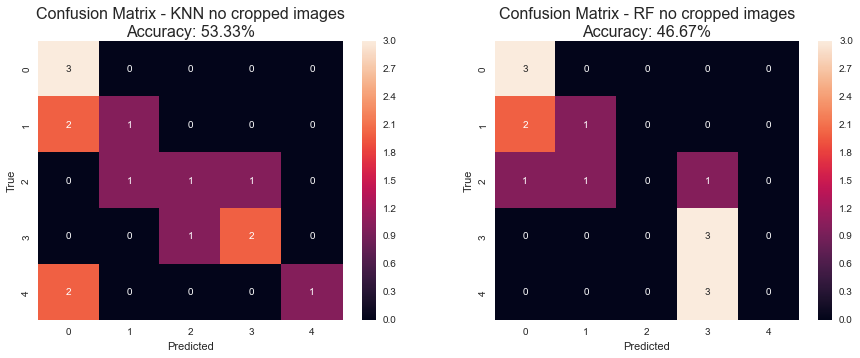

In [176]:
train_images_brute = np.reshape(train_images_res_gray,(5*7, 108**2))
test_images_brute = np.reshape(test_images_res_gray, (5*3, 108**2))

acc_brute_knn, cm_brute_knn = knn_classification(train_images_brute, test_images_brute, 1, 'euclidean')
acc_brute_rf, cm_brute_rf = rf_classification(train_images_brute, test_images_brute, 1, 0)

print('Descriptor length: {}'.format(np.shape(train_images_brute)[1]))

# make_heat_map_plt(cm_brute_knn, 'KNN no processing', acc_brute_knn)
# make_heat_map_plt(cm_brute_rf, 'RF no processing', acc_brute_rf)

params = zip(
    [cm_brute_knn, cm_brute_rf],
    ['KNN no cropped images', 'RF no cropped images'],
    [acc_brute_knn, acc_brute_rf])
make_heat_map_plt(params)

Descriptor length: 6400


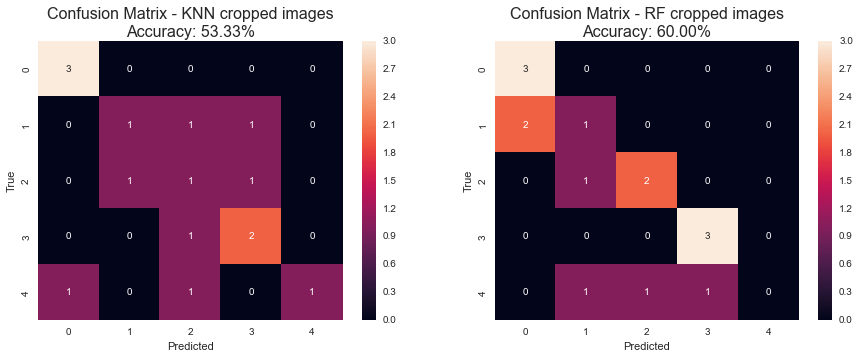

In [275]:
start_crop = 20
stop_crop = 100
train_images_crop = [[img[start_crop:stop_crop, start_crop:stop_crop] for img in gesture] for gesture in train_images_res_gray]
test_images_crop = [[img[start_crop:stop_crop, start_crop:stop_crop] for img in gesture] for gesture in test_images_res_gray]

train_fd_crop = np.reshape(train_images_crop,(5*7, (stop_crop-start_crop)**2))
test_fd_crop = np.reshape(test_images_crop, (5*3, (stop_crop-start_crop)**2))

acc_crop_knn, cm_crop_knn = knn_classification(train_fd_crop, test_fd_crop, 1, 'euclidean')
acc_crop_rf, cm_crop_rf = rf_classification(train_fd_crop, test_fd_crop, 1, 0)

print('Descriptor length: {}'.format(np.shape(train_crop_flat)[1]))

# make_heat_map_plt(cm_crop_knn, 'KNN cropped images', acc_crop_knn)
# make_heat_map_plt(cm_crop_rf, 'RF cropped images', acc_crop_rf)

params = zip(
    [cm_crop_knn, cm_crop_rf],
    ['KNN cropped images', 'RF cropped images'],
    [acc_crop_knn, acc_crop_rf])
make_heat_map_plt(params)

Descriptor length: 288


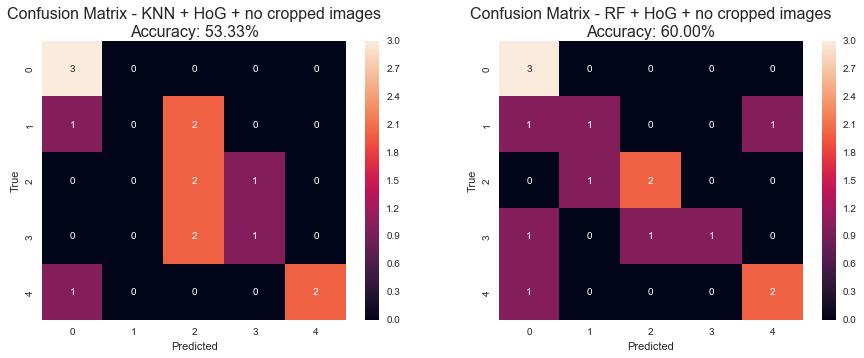

In [276]:
train_images_hog = make_hog(train_images_res_gray)
test_images_hog = make_hog(test_images_res_gray)

train_fd_hog = np.reshape(train_images_hog,(5*7, np.shape(test_images_hog)[2]))
test_fd_hog = np.reshape(test_images_hog, (5*3, np.shape(test_images_hog)[2]))

acc_hog_knn, cm_hog_knn = knn_classification(train_fd_hog, test_fd_hog, 1, 'euclidean')
acc_hog_rf, cm_hog_rf = rf_classification(train_fd_hog, test_fd_hog, 1, 0)

print('Descriptor length: {}'.format(np.shape(train_fd_hog)[1]))

params = zip(
    [cm_hog_knn, cm_hog_rf],
    ['KNN + HoG + no cropped images', 'RF + HoG + no cropped images'],
    [acc_hog_knn, acc_hog_rf])
make_heat_map_plt(params)

Descriptor length: 200


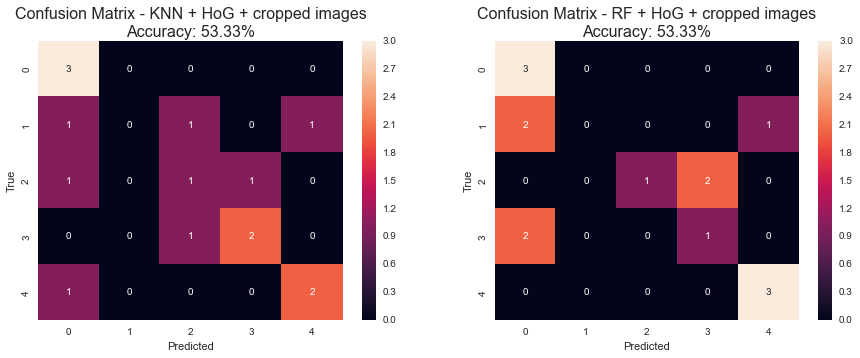

In [277]:
train_images_hog_cropped = make_hog(train_images_crop)
test_images_hog_cropped = make_hog(test_images_crop)


train_fd_hog_crop = np.reshape(train_images_hog_cropped,(5*7, np.shape(train_images_hog_cropped)[2]))
test_fd_hog_crop = np.reshape(test_images_hog_cropped, (5*3, np.shape(test_images_hog_cropped)[2]))

acc_hog_crop_knn, cm_hog_crop_knn = knn_classification(train_fd_hog_crop, test_fd_hog_crop, 1, 'euclidean')
acc_hog_crop_rf, cm_hog_crop_rf = rf_classification(train_fd_hog_crop, test_fd_hog_crop, 1, 0)

print('Descriptor length: {}'.format(np.shape(train_fd_hog_crop)[1]))

params = zip(
    [cm_hog_crop_knn, cm_hog_crop_rf],
    ['KNN + HoG + cropped images', 'RF + HoG + cropped images'],
    [acc_hog_crop_knn, acc_hog_crop_rf])
make_heat_map_plt(params)

In [278]:
train_fd_hog = np.reshape(train_images_hog,(5*7, np.shape(test_images_hog)[2]))
test_fd_hog = np.reshape(test_images_hog, (5*3, np.shape(test_images_hog)[2]))

scaling = [
    ('No scaling', train_fd_hog, test_fd_hog),
    ('Scale', preprocessing.scale(train_fd_hog), preprocessing.scale(test_fd_hog)),
    ('Normalize', normalize(train_fd_hog, norm='l2', axis=0, copy=True, return_norm=False), 
                  normalize(test_fd_hog, norm='l2', axis=0, copy=True, return_norm=False)),
    ('Min Max Scaler', MinMaxScaler().fit_transform(train_fd_hog), MinMaxScaler().fit_transform(test_fd_hog)),
    ('Max Abs Scaler', MaxAbsScaler().fit_transform(train_fd_hog), MaxAbsScaler().fit_transform(test_fd_hog))
]

knn_neighbors = [i for i in range(1, 10)]
knn_metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
rf_depth = [i for i in range(1, 10)]

In [279]:
knn_acc = []
for name, train, test in scaling:
    for neighbor in knn_neighbors:
        for metric in knn_metrics:
            knn = KNeighborsClassifier(n_neighbors=neighbor, metric=metric, algorithm='auto')
            knn.fit(train, y)
            y_knn_pred = [int(knn.predict(fd.reshape(1, -1))) for fd in test]
            knn_acc.append([name, neighbor, metric, accuracy_score(y_knn_pred, y_true)*100])
knn_df = pd.DataFrame(knn_acc)
knn_df.columns = ['Scaler', 'Neighbors', 'Metric', 'Accuracy']

       Scaler  Neighbors     Metric   Accuracy
72  Normalize          1  euclidean  86.666667
75  Normalize          1  minkowski  86.666667


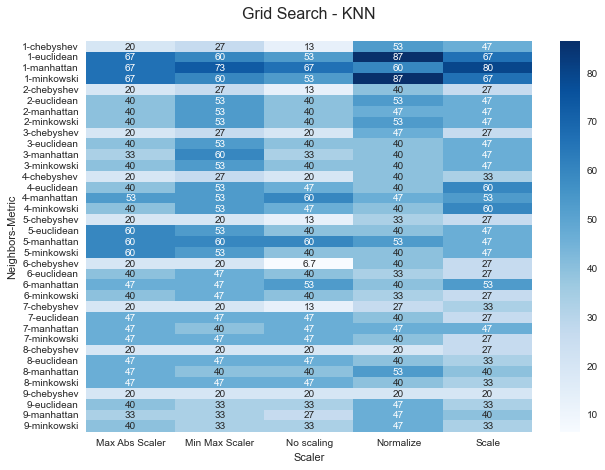

In [280]:
print(knn_df[knn_df.Accuracy == knn_df.Accuracy.max()])

heatmap1_data = pd.pivot_table(knn_df, values='Accuracy', 
                     index=['Neighbors', 'Metric'], 
                     columns=['Scaler'])

plt.figure(figsize=(10,7))
sn.heatmap(heatmap1_data, annot=True, cmap="Blues")
plt.title('Grid Search - KNN\n', fontsize=16)
plt.show()

In [281]:
rf_acc = []
for scaler, train, test in scaling:
    for depth in rf_depth:
        rf = RandomForestClassifier(max_depth=depth, random_state=0)
        rf.fit(train, y)
        y_rf_pred = [int(rf.predict(fd.reshape(1, -1))) for fd in test]
        rf_acc.append([scaler, depth, accuracy_score(y_rf_pred, y_true)*100])
rf_df = pd.DataFrame(rf_acc)
rf_df.columns = ['Scaler', 'Depth', 'Accuracy']

        Scaler  Depth   Accuracy
2   No scaling      3  93.333333
20   Normalize      3  93.333333


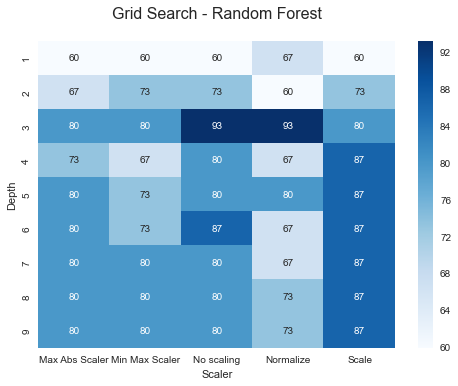

In [282]:
print(rf_df[rf_df.Accuracy == rf_df.Accuracy.max()])

heatmap1_data = pd.pivot_table(rf_df, values='Accuracy', 
                     index=['Depth'], 
                     columns='Scaler')

plt.figure()
sn.heatmap(heatmap1_data, annot=True, cmap="Blues")
plt.title('Grid Search - Random Forest\n', fontsize=16)
plt.show()

Descriptor length: 288


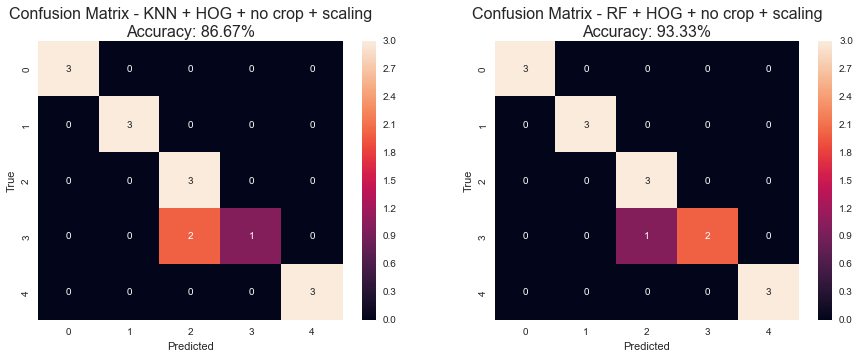

In [283]:
acc_gs_knn, cm_gs_knn = knn_classification(scaling[2][1], scaling[2][2], 1, 'euclidean')
acc_gs_rf, cm_gs_rf = rf_classification(scaling[2][1], scaling[2][2], 3, 0)

print('Descriptor length: {}'.format(np.shape(scaling[2][1])[1]))

# make_heat_map_plt(cm_brute_knn, 'KNN no processing', acc_brute_knn)
# make_heat_map_plt(cm_brute_rf, 'RF no processing', acc_brute_rf)

params = zip(
    [cm_gs_knn, cm_gs_rf],
    ['KNN + HOG + no crop + scaling', 'RF + HOG + no crop + scaling'],
    [acc_gs_knn, acc_gs_rf])
make_heat_map_plt(params)

In [284]:
train_fd_hog_crop = np.reshape(train_images_hog_cropped,(5*7, np.shape(test_images_hog_cropped)[2]))
test_fd_hog_crop = np.reshape(test_images_hog_cropped, (5*3, np.shape(test_images_hog_cropped)[2]))

scaling_crop = [
    ('No scaling', train_fd_hog_crop, test_fd_hog_crop),
    ('Scale', preprocessing.scale(train_fd_hog_crop), preprocessing.scale(test_fd_hog_crop)),
    ('Normalize', normalize(train_fd_hog_crop, norm='l2', axis=0, copy=True, return_norm=False), 
                  normalize(test_fd_hog_crop, norm='l2', axis=0, copy=True, return_norm=False)),
    ('Min Max Scaler', MinMaxScaler().fit_transform(train_fd_hog_crop), MinMaxScaler().fit_transform(test_fd_hog_crop)),
    ('Max Abs Scaler', MaxAbsScaler().fit_transform(train_fd_hog_crop), MaxAbsScaler().fit_transform(test_fd_hog_crop))
]

knn_neighbors = [i for i in range(1, 10)]
knn_metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
rf_depth = [i for i in range(1, 10)]

In [285]:
knn_acc_crop = []
for name, train, test in scaling_crop:
    for neighbor in knn_neighbors:
        for metric in knn_metrics:
            knn = KNeighborsClassifier(n_neighbors=neighbor, metric=metric, algorithm='auto')
            knn.fit(train, y)
            y_knn_pred = [int(knn.predict(fd.reshape(1, -1))) for fd in test]
            knn_acc_crop.append([name, neighbor, metric, accuracy_score(y_knn_pred, y_true)*100])
knn_crop_df = pd.DataFrame(knn_acc_crop)
knn_crop_df.columns = ['Scaler', 'Neighbors', 'Metric', 'Accuracy']

             Scaler  Neighbors     Metric   Accuracy
106       Normalize          9  chebyshev  66.666667
137  Min Max Scaler          8  manhattan  66.666667
141  Min Max Scaler          9  manhattan  66.666667
177  Max Abs Scaler          9  manhattan  66.666667


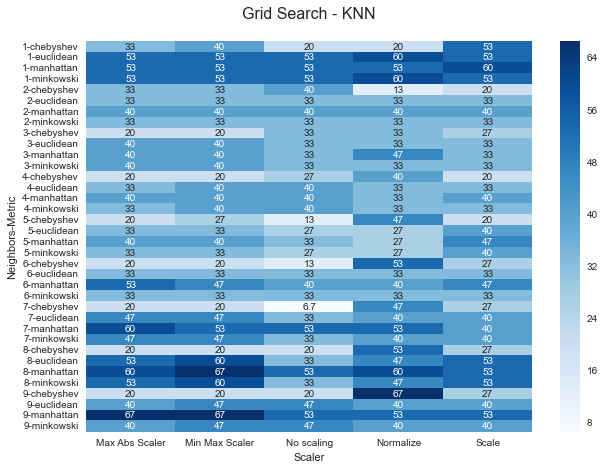

In [286]:
print(knn_crop_df[knn_crop_df.Accuracy == knn_crop_df.Accuracy.max()])

heatmap_knn_crop = pd.pivot_table(knn_crop_df, values='Accuracy', 
                     index=['Neighbors', 'Metric'], 
                     columns=['Scaler'])

plt.figure(figsize=(10,7))
sn.heatmap(heatmap_knn_crop, annot=True, cmap="Blues")
plt.title('Grid Search - KNN\n', fontsize=16)
plt.show()

In [287]:
rf_acc_crop = []
for scaler, train, test in scaling_crop:
    for depth in rf_depth:
        rf = RandomForestClassifier(max_depth=depth, random_state=0)
        rf.fit(train, y)
        y_rf_pred = [int(rf.predict(fd.reshape(1, -1))) for fd in test]
        rf_acc_crop.append([scaler, depth, accuracy_score(y_rf_pred, y_true)*100])
rf_crop_df = pd.DataFrame(rf_acc_crop)
rf_crop_df.columns = ['Scaler', 'Depth', 'Accuracy']

       Scaler  Depth  Accuracy
5  No scaling      6      80.0
6  No scaling      7      80.0
7  No scaling      8      80.0
8  No scaling      9      80.0


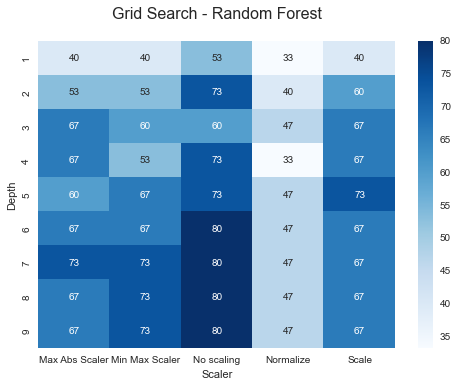

In [288]:
print(rf_crop_df[rf_crop_df.Accuracy == rf_crop_df.Accuracy.max()])

import seaborn as sn
plt.style.use('seaborn')

heatmap_rf_crop = pd.pivot_table(rf_crop_df, values='Accuracy', 
                     index=['Depth'], 
                     columns='Scaler')

plt.figure()
sn.heatmap(heatmap_rf_crop, annot=True, cmap="Blues")
plt.title('Grid Search - Random Forest\n', fontsize=16)
plt.show()